<a href="https://colab.research.google.com/github/myconcordia/A2I2/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Variational Autoencoder**

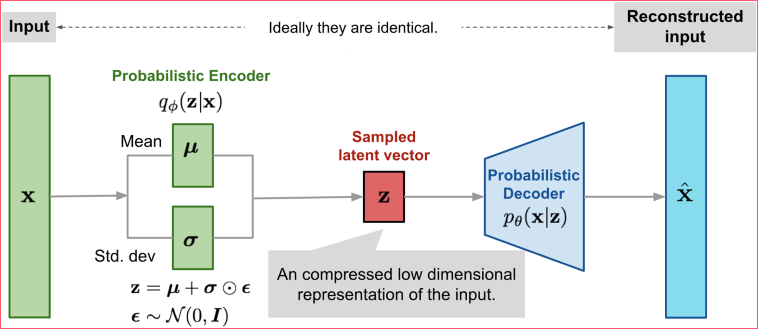

**Import Python Modules**

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import pandas as pd
import tensorflow as tf

from keras import backend as K
from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.datasets import mnist

# use seaborn plotting style defaults
import seaborn as sns; sns.set()


**Load and Prepare Data**

In [31]:
#Load Data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

#Normalize fdata: map gray scale 256 to number between zero and 1
X_train = X_train.astype("float32")/255.
X_test = X_test.astype("float32")/255.

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'training samples')
print(X_test.shape[0], 'test samples')

#Flatten the 28x28 images into 784-dimensional vectors
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

X_train shape: (60000, 28, 28, 1)
60000 training samples
10000 test samples


**Display Sample Images from the Training Set**

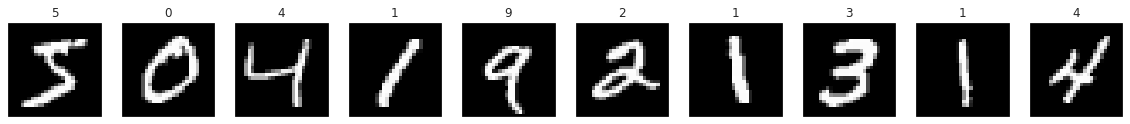

In [32]:
plt.figure(figsize=(20, 4))
for i in range(10):
  ax = plt.subplot(1, 10, i + 1)
  plt.imshow(X_train[i].reshape(28, 28))
  plt.title(y_train[i])
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

**Specify the Hyperparameters**

In [33]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2
batch_size = 100
epochs = 50
epsilon_std = 1.0

**Specify the Loss Function**

In [34]:
def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs

**Build the Variational Autoencoder**

In [35]:
class Sampling(Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [36]:
# Define encoder model.
original_inputs = Input(shape=(original_dim,), name="encoder_input")
x = Dense(intermediate_dim, activation="relu")(original_inputs)
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
z = Sampling()((z_mean, z_log_var))
encoder = Model(inputs=original_inputs, outputs=z, name="encoder")

# Define decoder model.
latent_inputs = Input(shape=(latent_dim,), name="z_sampling")
x = Dense(intermediate_dim, activation="relu")(latent_inputs)
outputs = Dense(original_dim, activation="sigmoid")(x)
decoder = Model(inputs=latent_inputs, outputs=outputs, name="decoder")

# Define VAE model.
outputs = decoder(z)
vae = Model(inputs=original_inputs, outputs=outputs, name="vae")
vae.compile(optimizer='adam', loss=nll)

**Display the structure of the autoencoder**

In [37]:
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 64)           50240       encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            130         dense_13[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            130         dense_13[0][0]                   
________________________________________________________________________________________________

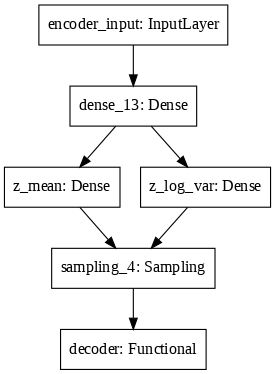

In [38]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

#SVG(model_to_dot(vae, show_shapes= False, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))
plot_model(model=vae, show_shapes=False, dpi=80, to_file='vae_full.png')

**Display the structure of the encoder**

In [39]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 64)           50240       encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            130         dense_13[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            130         dense_13[0][0]                   
____________________________________________________________________________________________

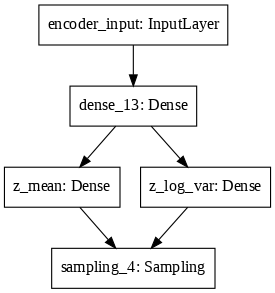

In [40]:
plot_model(model=encoder, show_shapes=False, dpi=80, to_file='vae_full.png')

**Display the structure of the decoder**

In [41]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                192       
_________________________________________________________________
dense_15 (Dense)             (None, 784)               50960     
Total params: 51,152
Trainable params: 51,152
Non-trainable params: 0
_________________________________________________________________


**Train the Autoencoder**

In [42]:
history = vae.fit(X_train, X_train,
                  shuffle=True,
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_data=(X_test, X_test))

Epoch 1/50
600/600 [==============================] - 2s 3ms/step - loss: 210.4572 - val_loss: 185.7854
Epoch 2/50
600/600 [==============================] - 2s 3ms/step - loss: 180.4771 - val_loss: 173.7234
Epoch 3/50
600/600 [==============================] - 2s 3ms/step - loss: 171.4465 - val_loss: 167.2681
Epoch 4/50
600/600 [==============================] - 2s 3ms/step - loss: 166.0085 - val_loss: 163.5214
Epoch 5/50
600/600 [==============================] - 2s 3ms/step - loss: 162.8965 - val_loss: 161.3528
Epoch 6/50
600/600 [==============================] - 2s 3ms/step - loss: 160.7471 - val_loss: 159.6438
Epoch 7/50
600/600 [==============================] - 2s 3ms/step - loss: 158.9610 - val_loss: 157.9428
Epoch 8/50
600/600 [==============================] - 2s 3ms/step - loss: 157.4952 - val_loss: 156.8488
Epoch 9/50
600/600 [==============================] - 2s 3ms/step - loss: 156.3099 - val_loss: 155.8132
Epoch 10/50
600/600 [==============================] - 2s 3ms/st

**Plot the Loss Functions**

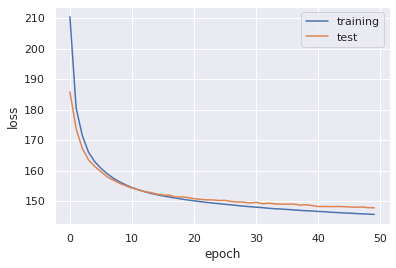

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'test'], loc='upper right')
plt.show()

**Visualization**

Because our latent space is two-dimensional, there are a few cool visualizations that can be done at this point. One is to look at the neighborhoods of different classes on the latent 2D plane:

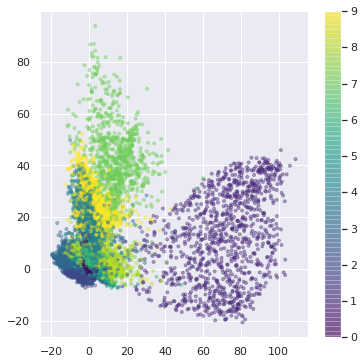

In [46]:
# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(X_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

**Evaluate the Model**

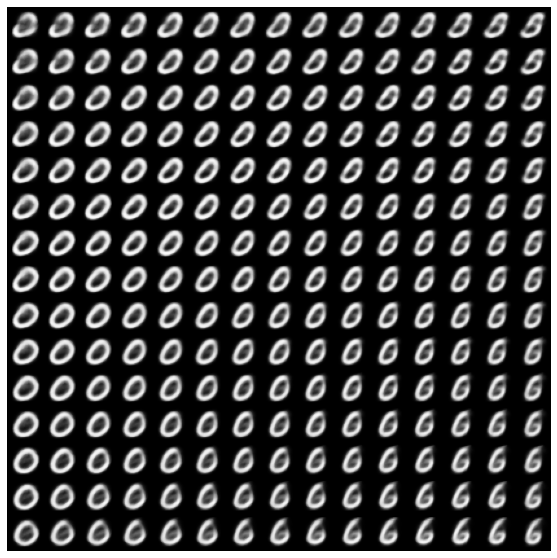

In [49]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian
u_grid = np.dstack(np.meshgrid(np.linspace(0.05, 0.95, n),
                               np.linspace(0.05, 0.95, n)))
z_grid = norm.ppf(u_grid)
x_decoded = decoder.predict(z_grid.reshape(n*n, 2))
x_decoded = x_decoded.reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_decoded))), cmap='Greys_r')
plt.axis('Off')
plt.show()